In [1]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

<IPython.core.display.Javascript object>

# SILAC Experiments

In [2]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

#function to format the protein id
def clean_id(temp_id):
    temp_id = temp_id.split(';')[0]
    if ':' in temp_id:
        temp_id=temp_id.split(':')[0]
    if temp_id.count('.')>=3:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    temp_id = temp_id.split('-')[0]
    return temp_id


In [3]:
#add back the description of the proteins
desc_dict = {}
path = 'TriTrypDB-32_TbruceiTREU927_AnnotatedProteins.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc

# Experiment 1


In [4]:
#read data and log transform for plots
df = pd.read_csv('TbdeAc2_0.3_digitonin/proteinGroups.txt',sep='\t')
df = clean(df)
df.head()

df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]


df['Gene_id_all'] = [    ';'.join([ clean_id(a) for a in n.split(';')]) for n in df['Protein IDs' ]  ]  
df['Gene_desc_all'] = [    '; '.join([ desc_dict[a].split('=')[1].strip() if a in desc_dict else 'none' for a in n.split(';')]) for n in df['Gene_id_all' ]  ]  

df['logInt']=np.log10(df['Intensity'])
df['logRatio_1']=np.log2(df['Ratio H/L normalized 1'])
df['logRatio_2']=np.log2(df['Ratio H/L normalized 2'])
df['logRatio_3']=np.log2(df['Ratio H/L normalized 3'])
df['logScore']=np.log10(df['Score'])
df.head()
print (df.shape)

removed  59 Only identified by site
tot  59  entries removed
---------------
removed  17 Reverse
tot  76  entries removed
---------------
removed  34 Potential contaminant
tot  110  entries removed
---------------
(1703, 121)


In [5]:
df['[Input ID]'] = df['Gene_id']
df.set_index('[Input ID]',inplace=True)
df.head()

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Oxidation (M) site positions,Gene_id,Gene_desc,Gene_id_all,Gene_desc_all,logInt,logRatio_1,logRatio_2,logRatio_3,logScore
[Input ID],,,,,,,,,,,,,,,,,,,,,
Tb927.5.4460,Tb927.5.4460:mRNA-p1;Tb05.5K5.110:mRNA-p1;Tb11...,Tb927.5.4460:mRNA-p1;Tb05.5K5.110:mRNA-p1,47;47;23,47;47;23,47;47;23,Tb927.5.4460:mRNA-p1 | transcript=Tb927.5.4460...,3,47,47,47,...,26;251;389;405;481;797;828,Tb927.5.4460,"major vault protein, putative",Tb927.5.4460;Tb05.5K5.110;Tb11.v5.0866,"major vault protein, putative; major vault pro...",8.808980,1.084541,1.272382,0.572502,2.509619
Tb927.5.4470,Tb927.5.4470:mRNA-p1;Tb05.5K5.120:mRNA-p1,Tb927.5.4470:mRNA-p1;Tb05.5K5.120:mRNA-p1,6;6,6;6,6;6,Tb927.5.4470:mRNA-p1 | transcript=Tb927.5.4470...,2,6,6,6,...,NaN,Tb927.5.4470,"hypothetical protein, conserved",Tb927.5.4470;Tb05.5K5.120,"hypothetical protein, conserved; hypothetical ...",6.141073,0.868529,0.045303,1.131985,1.156428
Tb927.5.4480,Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1,Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1,3;3,3;3,3;3,Tb927.5.4480:mRNA-p1 | transcript=Tb927.5.4480...,2,3,3,3,...,NaN,Tb927.5.4480,"paraflagellar rod component par4, putative",Tb927.5.4480;Tb05.5K5.130,"paraflagellar rod component par4, putative; pa...",5.733141,-1.177033,NaN,-0.599462,1.223755
Tb927.5.4500,Tb927.5.4500:mRNA-p1;Tb05.5K5.150:mRNA-p1,Tb927.5.4500:mRNA-p1;Tb05.5K5.150:mRNA-p1,3;3,3;3,3;3,Tb927.5.4500:mRNA-p1 | transcript=Tb927.5.4500...,2,3,3,3,...,NaN,Tb927.5.4500,"ras-like small GTPase, putative",Tb927.5.4500;Tb05.5K5.150,"ras-like small GTPase, putative; small GTP-bin...",5.146965,NaN,NaN,0.664665,0.555276
Tb927.5.4520,Tb927.5.4520:mRNA-p1;Tb05.5K5.160:mRNA-p1,Tb927.5.4520:mRNA-p1;Tb05.5K5.160:mRNA-p1,37;37,37;37,37;37,Tb927.5.4520:mRNA-p1 | transcript=Tb927.5.4520...,2,37,37,37,...,236;287;288;401;412;463;894,Tb927.5.4520,Kinetochore interacting protein 1,Tb927.5.4520;Tb05.5K5.160,Kinetochore interacting protein 1; hypothetica...,7.909187,1.003026,1.062536,2.020164,2.387319


In [6]:
evidence = pd.read_table('TbdeAc2_0.3_digitonin/evidence.txt',sep='\t')
evidence['prot_id']=[clean_id(n) for n in evidence['Leading razor protein']]
evidence = evidence[evidence['prot_id'].isin(df.index.values)]
evidence.head()

,Sequence,Length,K Count,R Count,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),...,Potential contaminant,id,Protein group IDs,Peptide ID,Mod. peptide ID,MS/MS IDs,Best MS/MS,AIF MS/MS IDs,Oxidation (M) site IDs,prot_id
0,AAAATLPVGLVPAPPK,16,1,0,Unmodified,_AAAATLPVGLVPAPPK_,NaN,NaN,0,0,...,NaN,0,593,0,0,0;1,0.0,NaN,NaN,Tb927.11.1110
1,AAADIGFPMMVR,12,0,1,2 Oxidation (M),_AAADIGFPM(ox)M(ox)VR_,AAADIGFPM(1)M(1)VR,AAADIGFPM(72.64)M(72.64)VR,0,2,...,NaN,1,1255,1,1,2;3,3.0,NaN,1541;1542,Tb927.5.3800
2,AAADIGFPMMVR,12,0,1,2 Oxidation (M),_AAADIGFPM(ox)M(ox)VR_,AAADIGFPM(1)M(1)VR,AAADIGFPM(86.62)M(86.62)VR,0,2,...,NaN,2,1255,1,1,4;5,5.0,NaN,1541;1542,Tb927.5.3800
3,AAADIGFPMMVR,12,0,1,2 Oxidation (M),_AAADIGFPM(ox)M(ox)VR_,AAADIGFPM(1)M(1)VR,AAADIGFPM(70.91)M(70.91)VR,0,2,...,NaN,3,1255,1,1,6;7,6.0,NaN,1541;1542,Tb927.5.3800
4,AAADIGFPMMVR,12,0,1,Oxidation (M),_AAADIGFPM(ox)MVR_,AAADIGFPM(0.503)M(0.497)VR,AAADIGFPM(0.06)M(-0.06)VR,0,1,...,NaN,4,1255,1,2,8;9,8.0,NaN,1541;1542,Tb927.5.3800


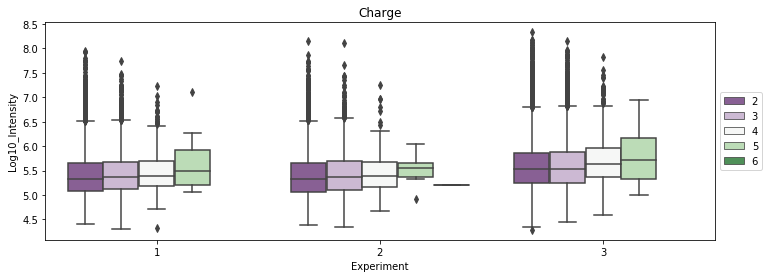

In [7]:
def make_plot(df=pd.DataFrame(), 
              x='', y='', hue='', ax='', 
              legend=False, title =False):
    import seaborn as sns
    #fig, ax = plt.subplots()
    sns.boxplot(x=x, y=y, hue=hue, data=df, palette="PRGn", ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if title:
        ax.set_title(title)
    else:
        ax.set_title(hue)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_visible(legend)
    #ax.legend.visible=False
    
fig,axes = plt.subplots(ncols=1, nrows=1, figsize=(12,4))   
evidence['Log10_Intensity']=np.log10(evidence['Intensity'])
make_plot(df=evidence, x='Experiment', y='Log10_Intensity', hue='Charge',ax=axes, legend=True, title='Charge')
plt.show()


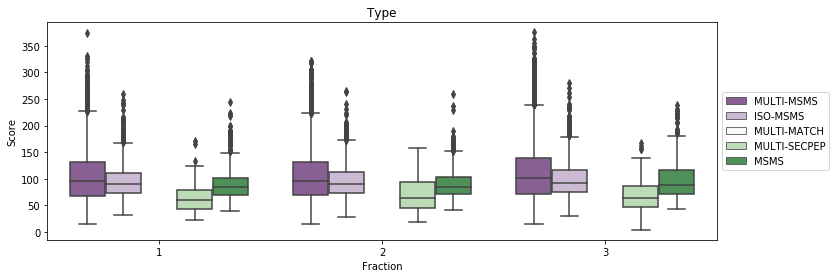

In [8]:
'''
- MULTI-MSMS:     label pair detected
- MULTI-SECPEP  identification through second peptide algorithm
- MULTI-MATCH    identification based on match between runs
- ISO-MSMS:         isotope cluster detected but no label pair
- MSMS:                no MS1 label state detected  
The type of MS/MS spectrum this sequence is derived from.
MSMS – MS/MS for an unidentified peak.
ISO-MSMS – MS/MS from an identified isotope cluster.
MULTI-MSMS – MS/MS from an identified labeling cluster
'''
fig,axes = plt.subplots(ncols=1, nrows=1, figsize=(12,4))   
make_plot(df=evidence, x='Experiment', y='Score', hue='Type',ax=axes, legend=True, title='Type')
plt.xlabel('Fraction')
plt.show()

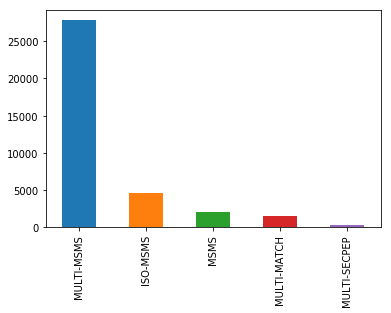

In [9]:
evidence['Type'].value_counts().plot(kind='bar')

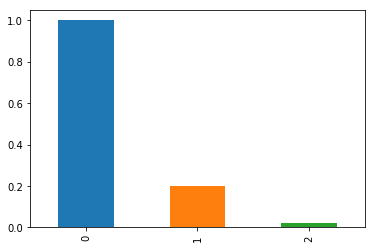

In [10]:
temp = evidence['Missed cleavages'].value_counts()/evidence['Missed cleavages'].value_counts().loc[0]
temp.sort_index(inplace=True)
temp.plot(kind='bar')

In [11]:
#get glycosome data
ref_df = pd.read_csv('out_data/glycosome_experiment_extended.txt',sep='\t')    
ref_df['[Ortholog Group]']=ref_df['[Ortholog Group]'].astype('category')
ref_df['ortho_codes']=ref_df['[Ortholog Group]'].cat.codes
ref_df['[Input ID]']=[n.replace(' ','') for n in ref_df['[Input ID]']]
ref_df.set_index('[Input ID]',inplace=True)  
#print (ref_df.head())

lucia_experiments = pd.read_table('out_data/glycosome_experiment.txt',sep='\t')
lucia_experiments['[Input ID]']=lucia_experiments['GeneDB IDs']
lucia_experiments['[Input ID]']=[n.replace(' ','') for n in lucia_experiments['[Input ID]']]
lucia_experiments.set_index('[Input ID]',inplace=True)
#print (lucia_experiments.head())


ref_df = ref_df.join(lucia_experiments,how='left')
ref_df.drop_duplicates(subset=['[Gene ID]'],inplace=True)
ref_df.set_index('[Gene ID]',inplace=True,drop=True)
ref_df=ref_df[['Log2 H/L','Log10 (Int H*L)','Group', 'Glycosome status ']]
ref_df.head()

,Log2 H/L,Log10 (Int H*L),Group,Glycosome status
[Gene ID],,,,
Tb06.3A7.270,-0.113504,11.743189,i,red
Tb927.9.1350,0.020373,13.847976,i,red
Tb927.9.1360,0.034075,11.430029,i,red
Tb927.9.1380,0.158678,12.763610,i,red
Tb927.9.1410,0.002214,13.992089,i,red


In [12]:
#get transmembrane and peptide signal from TryTripDB
tm = pd.read_csv('GeneByLocusTag_Summary.txt',sep='\t')
tm.drop_duplicates(subset=['[Input ID]'],inplace=True)
tm.set_index('[Input ID]',inplace=True)

df['[Input ID]'] = df['Gene_id']
df.set_index('[Input ID]',inplace=True)
df = df.join(tm, how='left')
df['[SignalP Peptide]'] = [1 if str(n) != 'nan' else 0 for n in df['[SignalP Peptide]'] ] 

In [13]:
#add number of unique peptide identified
df['unique'] = [int(n.split(';')[0]) for n in df['Peptide counts (unique)']]

In [14]:
#select some fielsd from the full output
selection = df[['Gene_desc', 'unique',  
                'logRatio_1', 'logRatio_2', 'logRatio_3','Score',
                'logScore', 'logInt',
                '[SignalP Peptide]','[# TM Domains]', 'Gene_id_all', 'Gene_desc_all']]
selection.dropna(inplace=True)

selection['logratio_mean']=selection[['logRatio_1', 'logRatio_2', 'logRatio_3']].mean(axis=1)
selection.sort_values('logratio_mean', inplace=True, ascending =False)
#selection=selection.join(ref_df, how='left')
#selection.to_csv('silac_Tb927.3.2610/silac_clean.csv')
selection.head(5)

,Gene_desc,unique,logRatio_1,logRatio_2,logRatio_3,Score,logScore,logInt,[SignalP Peptide],[# TM Domains],Gene_id_all,Gene_desc_all,logratio_mean
[Input ID],,,,,,,,,,,,,
Tb927.3.2610,GPI inositol deacylase 2,8,3.747495,3.897628,4.430486,33.732,1.528042,6.889828,0,10.0,Tb927.3.2610,GPI inositol deacylase 2,4.025203
Tb927.4.4580,"hypothetical protein, conserved",25,2.117928,2.355383,2.178874,211.310,2.324920,7.729594,0,0.0,Tb927.4.4580,"hypothetical protein, conserved",2.217395
Tb927.11.13110,"hypothetical protein, conserved",6,1.991390,1.543248,2.064848,18.471,1.266490,6.486884,0,0.0,Tb927.11.13110,"hypothetical protein, conserved",1.866496
Tb927.11.15450,Basal body protein,21,1.715718,2.125783,1.523863,314.010,2.496943,7.864351,0,0.0,Tb927.11.15450,Basal body protein,1.788455
Tb927.10.11340,"hypothetical protein, conserved",16,1.566718,1.509747,2.022545,76.393,1.883054,7.090787,1,0.0,Tb927.10.11340;Tb11.v5.0604,"hypothetical protein, conserved; hypothetical ...",1.699670


In [15]:
#replace missing values with average
#t-test 3 replicates versus 0,0,0
from scipy import stats
selection[['logRatio_1', 'logRatio_2', 'logRatio_3']] =selection[['logRatio_1', 'logRatio_2', 'logRatio_3']].fillna(selection[['logRatio_1', 'logRatio_2', 'logRatio_3']].mean())
statistics = []
pvalues = []
for prot in selection.index.values:
    statistic, pvalue = stats.ttest_ind(selection[['logRatio_1', 'logRatio_2', 'logRatio_3']].loc[prot].values,np.array([0,0,0]))
    statistics.append(statistic)
    pvalues.append(pvalue)
selection['pvalues']=pvalues
selection['statistics']=statistics

In [16]:
selection['log_pvalues']=-np.log10(selection['pvalues'])

In [17]:
from statsmodels.sandbox.stats.multicomp import multipletests
padj = multipletests(selection['pvalues'], method='bonferroni')
selection['padj']=padj[1]

In [18]:
selection[selection['padj']<0.05].head(10)

,Gene_desc,unique,logRatio_1,logRatio_2,logRatio_3,Score,logScore,logInt,[SignalP Peptide],[# TM Domains],Gene_id_all,Gene_desc_all,logratio_mean,pvalues,statistics,log_pvalues,padj
[Input ID],,,,,,,,,,,,,,,,,
Tb927.3.2610,GPI inositol deacylase 2,8,3.747495,3.897628,4.430486,33.732,1.528042,6.889828,0,10.0,Tb927.3.2610,GPI inositol deacylase 2,4.025203,4.141222e-05,19.424371,4.382871,0.027084
Tb927.4.4580,"hypothetical protein, conserved",25,2.117928,2.355383,2.178874,211.310,2.324920,7.729594,0,0.0,Tb927.4.4580,"hypothetical protein, conserved",2.217395,6.335277e-06,31.142363,5.198234,0.004143
Tb927.9.8820,"hypothetical protein, conserved",14,1.485169,1.612824,1.797553,103.580,2.015276,7.157366,0,0.0,Tb927.9.8820,"hypothetical protein, conserved",1.631849,5.604602e-05,17.996156,4.251455,0.036654
Tb927.7.6610,"hypothetical protein, conserved",10,1.341815,1.495695,1.382114,43.722,1.640700,6.858375,0,0.0,Tb927.7.6610,"hypothetical protein, conserved",1.406541,6.856617e-06,30.530604,5.163890,0.004484
Tb927.11.10150,"Enoyl-CoA hydratase/isomerase family, putative",25,1.210451,1.062053,1.206706,159.890,2.203821,7.240399,0,0.0,Tb927.11.10150,"Enoyl-CoA hydratase/isomerase family, putative",1.159737,1.867201e-05,23.738864,4.728809,0.012211
Tb927.8.5200,"hypothetical protein, conserved",40,1.061085,1.070870,1.154842,128.820,2.109983,7.525951,0,0.0,Tb927.8.5200,"hypothetical protein, conserved",1.095599,3.248705e-06,36.819430,5.488290,0.002125
Tb927.4.4060,"hypothetical protein, conserved",5,1.056514,1.114900,1.099766,15.428,1.188310,6.429865,0,0.0,Tb927.4.4060,"hypothetical protein, conserved",1.090394,3.968494e-07,62.329716,6.401374,0.000260
Tb927.4.4550,"hypothetical protein, conserved",5,1.038858,0.909197,0.998340,19.133,1.281783,6.512164,0,0.0,Tb927.4.4550,"hypothetical protein, conserved",0.982132,1.373235e-05,25.645087,4.862255,0.008981
Tb927.8.2390,"hypothetical protein, conserved",12,0.979294,0.942383,0.836005,53.755,1.730419,6.849622,0,0.0,Tb927.8.2390,"hypothetical protein, conserved",0.919227,2.819470e-05,21.400408,4.549833,0.018439


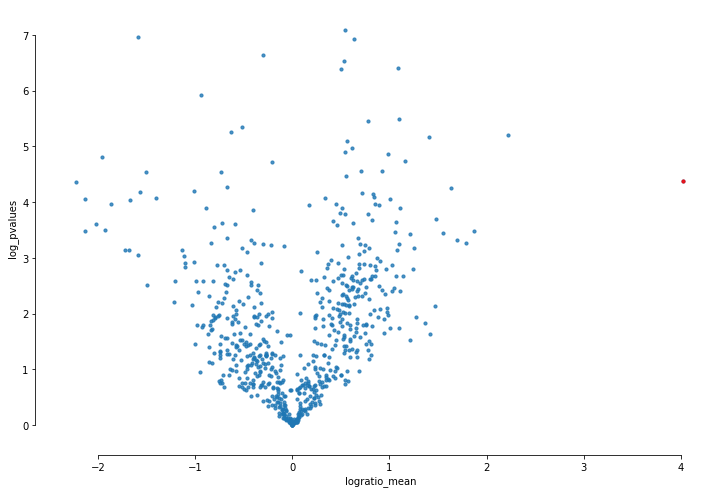

In [19]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='logratio_mean', y='log_pvalues', 
            fit_reg=False, data = selection,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
sns.regplot(x='logratio_mean', y='log_pvalues', 
            fit_reg=False, data = selection.loc[['Tb927.3.2610']],
            ax=ax, scatter_kws={'s':10,'color':'red'})

plt.show()

In [20]:
#interactive plot
trace_1 = go.Scatter(
    x=selection.logratio_mean,
    y=selection.log_pvalues,
    mode='markers',
    name='Vulacano Plot',
    text = [a + ' ' +b + ' '+str(round(c,1)) for a,b,c in zip(selection.index.values, selection.Gene_desc, selection.logScore )],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = np.log10(selection.logScore), #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[selection.logratio_mean.loc['Tb927.3.2610']],
    y=[selection.log_pvalues.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)



layout = dict(title='Vulacano SILAC')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

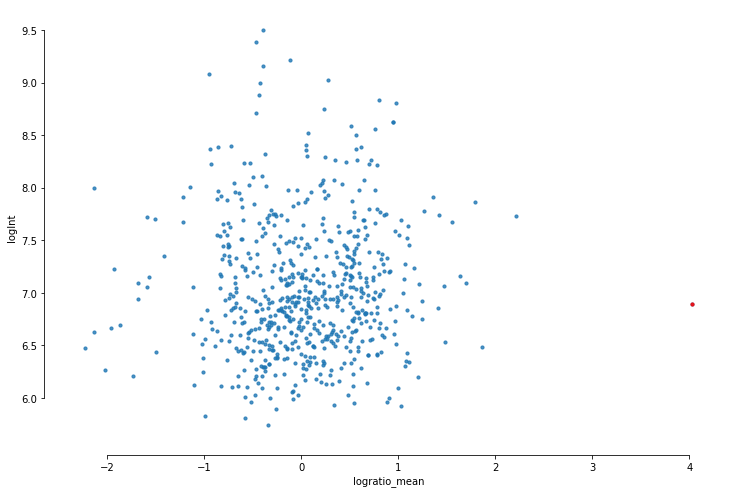

In [21]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='logratio_mean', y='logInt', 
            fit_reg=False, data = selection,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
sns.regplot(x='logratio_mean', y='logInt', 
            fit_reg=False, data = selection.loc[['Tb927.3.2610']],
            ax=ax, scatter_kws={'s':10,'color':'red'})

plt.show()


# Experiment Reproducibility

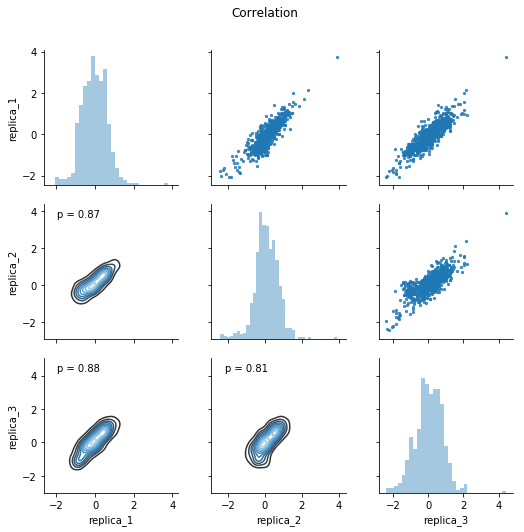

In [22]:
#select dataset
temp = selection[['logRatio_1',
           'logRatio_2',
           'logRatio_3']]

#rename dataset columns with the first author name
temp.columns = ['replica_1', 'replica_2', 'replica_3']

#plot the correlation
def corrfunc(x, y, **kws):
    corr = np.corrcoef(x, y)
    r = corr[0][1]
    ax = plt.gca()
    ax.annotate("p = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
g = sns.PairGrid(temp.dropna(), palette=["red"])
g.map_upper(plt.scatter, s=5,alpha=0.8)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation') 
plt.show()


# Analysis with intensities

In [23]:
#select some fielsd from the full output
selection = df[['Gene_desc',  
                'Intensity L 1',
                'Intensity H 1',
                'Intensity L 2',
                'Intensity H 2',
                'Intensity L 3',
                'Intensity H 3',
                'Score',
                'logScore', 
                'logInt',
                 'Gene_id_all', 'Gene_desc_all']]

replace_1 = selection['Intensity L 1'][selection['Intensity L 1']>0].min()
replace_2 =selection['Intensity L 2'][selection['Intensity L 2']>0].min()
replace_3 =selection['Intensity L 3'][selection['Intensity L 3']>0].min()

replace_3 = selection['Intensity H 1'][selection['Intensity H 1']>0].min()
replace_4 =selection['Intensity H 2'][selection['Intensity H 2']>0].min()
replace_5 =selection['Intensity H 3'][selection['Intensity H 3']>0].min()

selection['Intensity L 1'].fillna(replace_1, inplace=True)
selection['Intensity L 2'].fillna(replace_2, inplace=True)
selection['Intensity L 3'].fillna(replace_3, inplace=True)
selection['Intensity L 1'].replace(0,replace_1, inplace=True)
selection['Intensity L 2'].replace(0,replace_2, inplace=True)
selection['Intensity L 3'].replace(0,replace_3, inplace=True)

selection['Intensity H 1'].fillna(replace_3, inplace=True)
selection['Intensity H 2'].fillna(replace_4, inplace=True)
selection['Intensity H 3'].fillna(replace_5, inplace=True)
selection['Intensity H 1'].replace(0,replace_3, inplace=True)
selection['Intensity H 2'].replace(0,replace_4, inplace=True)
selection['Intensity H 3'].replace(0,replace_5, inplace=True)


selection['Intensity HL 1']=np.log2(selection['Intensity H 1']/selection['Intensity L 1'])
selection['Intensity HL 2']=np.log2(selection['Intensity H 2']/selection['Intensity L 2'])
selection['Intensity HL 3']=np.log2(selection['Intensity H 3']/selection['Intensity L 3'])
selection['logratio_mean']=selection[['Intensity HL 1','Intensity HL 2','Intensity HL 3']].mean(axis=1)
selection.head(5)

,Gene_desc,Intensity L 1,Intensity H 1,Intensity L 2,Intensity H 2,Intensity L 3,Intensity H 3,Score,logScore,logInt,Gene_id_all,Gene_desc_all,Intensity HL 1,Intensity HL 2,Intensity HL 3,logratio_mean
[Input ID],,,,,,,,,,,,,,,,
Tb927.5.4460,"major vault protein, putative",71930000,130390000.0,37734000,85365000.0,117950000.0,200780000.0,323.3100,2.509619,8.808980,Tb927.5.4460;Tb05.5K5.110;Tb11.v5.0866,"major vault protein, putative; major vault pro...",0.858168,1.177780,0.767440,0.934463
Tb927.5.4470,"hypothetical protein, conserved",85121,188840.0,104530,132580.0,270230.0,602510.0,14.3360,1.156428,6.141073,Tb927.5.4470;Tb05.5K5.120,"hypothetical protein, conserved; hypothetical ...",1.149577,0.342946,1.156797,0.883107
Tb927.5.4480,"paraflagellar rod component par4, putative",153710,66426.0,12294,8448.8,188760.0,132030.0,16.7400,1.223755,5.733141,Tb927.5.4480;Tb05.5K5.130,"paraflagellar rod component par4, putative; pa...",-1.210391,-0.541136,-0.515687,-0.755738
Tb927.5.4500,"ras-like small GTPase, putative",8455,7736.3,12294,8448.8,53176.0,87094.0,3.5915,0.555276,5.146965,Tb927.5.4500;Tb05.5K5.150,"ras-like small GTPase, putative; small GTP-bin...",-0.128161,-0.541136,0.711798,0.014167
Tb927.5.4520,Kinetochore interacting protein 1,10582000,18325000.0,8185500,15915000.0,5120500.0,23003000.0,243.9600,2.387319,7.909187,Tb927.5.4520;Tb05.5K5.160,Kinetochore interacting protein 1; hypothetica...,0.792201,0.959245,2.167465,1.306304


In [24]:
#replace missing values with average
#t-test 3 replicates versus 0,0,0
from scipy import stats
selection[['Intensity HL 1', 'Intensity HL 2', 'Intensity HL 3']] =selection[['Intensity HL 1', 'Intensity HL 2', 'Intensity HL 3']].fillna(selection[['Intensity HL 1', 'Intensity HL 2', 'Intensity HL 3']].mean())
statistics = []
pvalues = []
for prot in selection.index.values:
    statistic, pvalue = stats.ttest_ind(selection[['Intensity HL 1', 'Intensity HL 2', 'Intensity HL 3']].loc[prot].values,np.array([0,0,0]))
    statistics.append(statistic)
    pvalues.append(pvalue)
selection['pvalues']=pvalues
selection['statistics']=statistics
selection['log_pvalues']=-np.log10(selection['pvalues'])
from statsmodels.sandbox.stats.multicomp import multipletests
padj = multipletests(selection['pvalues'], method='bonferroni')
selection['padj']=padj[1]
selection.head()

,Gene_desc,Intensity L 1,Intensity H 1,Intensity L 2,Intensity H 2,Intensity L 3,Intensity H 3,Score,logScore,logInt,Gene_id_all,Gene_desc_all,Intensity HL 1,Intensity HL 2,Intensity HL 3,logratio_mean,pvalues,statistics,log_pvalues,padj
[Input ID],,,,,,,,,,,,,,,,,,,,
Tb927.5.4460,"major vault protein, putative",71930000,130390000.0,37734000,85365000.0,117950000.0,200780000.0,323.3100,2.509619,8.808980,Tb927.5.4460;Tb05.5K5.110;Tb11.v5.0866,"major vault protein, putative; major vault pro...",0.858168,1.177780,0.767440,0.934463,0.001683,7.508990,2.773855,1.0
Tb927.5.4470,"hypothetical protein, conserved",85121,188840.0,104530,132580.0,270230.0,602510.0,14.3360,1.156428,6.141073,Tb927.5.4470;Tb05.5K5.120,"hypothetical protein, conserved; hypothetical ...",1.149577,0.342946,1.156797,0.883107,0.030798,3.269695,1.511477,1.0
Tb927.5.4480,"paraflagellar rod component par4, putative",153710,66426.0,12294,8448.8,188760.0,132030.0,16.7400,1.223755,5.733141,Tb927.5.4480;Tb05.5K5.130,"paraflagellar rod component par4, putative; pa...",-1.210391,-0.541136,-0.515687,-0.755738,0.029304,-3.322727,1.533076,1.0
Tb927.5.4500,"ras-like small GTPase, putative",8455,7736.3,12294,8448.8,53176.0,87094.0,3.5915,0.555276,5.146965,Tb927.5.4500;Tb05.5K5.150,"ras-like small GTPase, putative; small GTP-bin...",-0.128161,-0.541136,0.711798,0.014167,0.971185,0.038432,0.012698,1.0
Tb927.5.4520,Kinetochore interacting protein 1,10582000,18325000.0,8185500,15915000.0,5120500.0,23003000.0,243.9600,2.387319,7.909187,Tb927.5.4520;Tb05.5K5.160,Kinetochore interacting protein 1; hypothetica...,0.792201,0.959245,2.167465,1.306304,0.039357,3.014969,1.404973,1.0


In [25]:
#interactive plot
trace_1 = go.Scatter(
    x=selection.logratio_mean,
    y=selection.log_pvalues,
    mode='markers',
    name='Vulacano Plot',
    text = [a + ' ' +b + ' '+str(round(c,1)) for a,b,c in zip(selection.index.values, selection.Gene_desc, selection.logScore )],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = np.log10(selection.logScore), #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[selection.logratio_mean.loc['Tb927.3.2610']],
    y=[selection.log_pvalues.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)



layout = dict(title='Vulacano SILAC')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

In [26]:
#interactive plot
trace_1 = go.Scatter(
    x=selection.logratio_mean,
    y=selection.logInt,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b + ' '+str(round(c,1)) for a,b,c in zip(selection.index.values, selection.Gene_desc, selection.logScore )],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = np.log10(selection.logScore), #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[selection.logratio_mean.loc['Tb927.3.2610']],
    y=[selection.logInt.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)



layout = dict(title='MA SILAC')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

In [ ]:
selection.to_csv('silac_Tb927.3.2610/Analysis_2_dig_03.csv')